<a href="https://colab.research.google.com/github/Arnouux/NLP_tweets/blob/main/transformer_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

## Libraries

### Install the ones that may not be present on the system

In [1]:
!pip install datasets
!pip install transformers

     |████████████████████████████████| 298 kB 5.2 MB/s 
     |████████████████████████████████| 61 kB 445 kB/s 
     |████████████████████████████████| 132 kB 46.5 MB/s 
     |████████████████████████████████| 243 kB 37.2 MB/s 
     |████████████████████████████████| 1.1 MB 32.7 MB/s 
     |████████████████████████████████| 192 kB 51.0 MB/s 
     |████████████████████████████████| 271 kB 47.9 MB/s 
     |████████████████████████████████| 160 kB 39.1 MB/s 
     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 44.6 MB/s 
     |████████████████████████████████| 3.3 MB 50.1 MB/s 
     |████████████████████████████████| 596 kB 43.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Import the others

In [2]:
import functools
import sys

import datasets
import matplotlib.pyplot as plt
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import transformers

## Seed randomness

In [3]:
seed = 0

torch.manual_seed(seed)
np.random.seed(seed)

## Form the correct datasets

### Make the files accessible to the script

We use the drive to store the file, then grant access to Colab to the particular folder containing the relevant files

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!rm -rf "twitter-datasets"
!cp -r "drive/MyDrive/data" "twitter-datasets"
# WARNING: You may need to change this path ("drive/MyDrive/data"). 
# This path is valid if you have a folder "data" on your drive that contains all the necessary files.
# The root folder of your Google Drive is "drive/MyDrive", then the path works as usual.

In [7]:
FILE_NEG = "twitter-datasets/train_neg.txt"
FILE_POS = "twitter-datasets/train_pos.txt"
FILE_NEG_FULL = "twitter-datasets/train_neg_full.txt"
FILE_POS_FULL = "twitter-datasets/train_pos_full.txt"
FILE_TEST = "twitter-datasets/test_data.txt"

### Generating the train entries dataset

In [8]:
entries_dict = {"label":[], "text":[]}

#### Reading the files

In [9]:
with open(FILE_NEG, "r") as f:
    content = f.read()
content = content.split("\n")
for entry in content:
    if entry == "" or entry == " ":
        continue
    entries_dict["text"].append(entry)
    entries_dict["label"].append(0)
with open(FILE_POS, "r") as f:
    content = f.read()
content = content.split("\n")
for entry in content:
    if entry == "" or entry == " ":
        continue
    entries_dict["text"].append(entry)
    entries_dict["label"].append(1)

#### Splitting the dataset into two

In [10]:
test_size = 0.25
dataset = datasets.Dataset.from_dict(
    entries_dict
)
train_valid_data = dataset.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

#### Transform the inputs from sentence of words to numerical values

In [ ]:
transformer_name = 'bert-base-uncased'

tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)

In [12]:
def tokenize_and_numericalize_data(example, tokenizer):
    ids = tokenizer(example['text'], truncation=True)['input_ids']
    return {'ids': ids}

In [ ]:
train_data = train_data.map(
    tokenize_and_numericalize_data, 
    fn_kwargs={'tokenizer': tokenizer}
)
valid_data = valid_data.map(
    tokenize_and_numericalize_data,
    fn_kwargs={'tokenizer': tokenizer}
)

In [14]:
pad_index = tokenizer.pad_token_id

In [15]:
train_data = train_data.with_format(
    type="torch",
    columns=["ids", "label"]
)
valid_data = valid_data.with_format(
    type="torch",
    columns=["ids", "label"]
)

#### Batchs formation

In [23]:
def collate(batch, pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(
        batch_ids,
        padding_value=pad_index,
        batch_first=True
    )
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'label': batch_label}
    return batch

In [24]:
batch_size = 8

collate = functools.partial(collate, pad_index=pad_index)

train_dataloader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    collate_fn=collate, 
    shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(
    valid_data,
    batch_size=batch_size,
    collate_fn=collate
)

# Neural Network

In [ ]:
transformer = transformers.AutoModel.from_pretrained(transformer_name)

## Transformer Class

The class containing the neural network

In [17]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False
        
    def forward(self, ids):
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        attention = output.attentions[-1]
        cls_hidden = hidden[:,0,:]
        prediction = self.fc(torch.tanh(cls_hidden))
        return prediction

## Initialization

In [18]:
output_dim = len(train_data['label'].unique())
freeze = False

model = Transformer(transformer, output_dim, freeze)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

In [20]:
lr = 1e-5

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
model = model.to(device)
criterion = criterion.to(device)

## Train/Evaluate functions

In [25]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [26]:
def train(dataloader, model, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        label = batch['label'].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [27]:
def evaluate(dataloader, model, criterion, device):
    
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            label = batch['label'].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

## Training

In [28]:
n_epochs = 3
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(n_epochs):

    train_loss, train_acc = train(
        train_dataloader,
        model,
        criterion,
        optimizer,
        device
    )
    valid_loss, valid_acc = evaluate(
        valid_dataloader,
        model,
        criterion,
        device
    )

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)
    
    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)
    
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'transformer.pt')
    
    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

evaluating...: 100%|██████████| 6250/6250 [06:08<00:00, 16.95it/s]
epoch: 1
train_loss: 0.316, train_acc: 0.860
valid_loss: 0.273, valid_acc: 0.883
evaluating...: 100%|██████████| 6250/6250 [06:09<00:00, 16.92it/s]
epoch: 2
train_loss: 0.225, train_acc: 0.907
valid_loss: 0.278, valid_acc: 0.885
evaluating...: 100%|██████████| 6250/6250 [06:08<00:00, 16.94it/s]
epoch: 3
train_loss: 0.146, train_acc: 0.942
valid_loss: 0.326, valid_acc: 0.883


## Training stats display

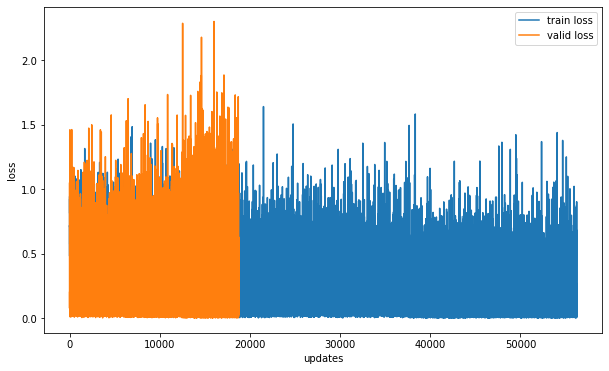

In [29]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss');

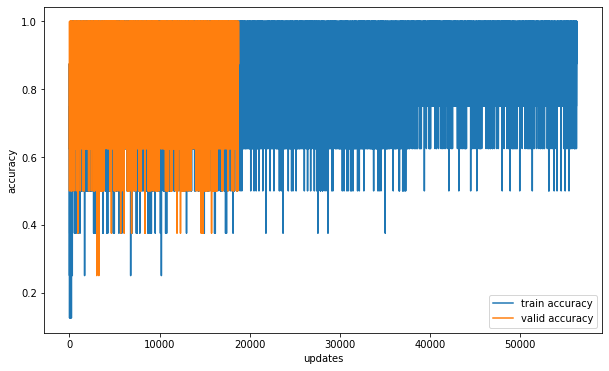

In [30]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy');

# Predictions

## Load the best model

In [31]:
model.load_state_dict(torch.load('transformer.pt'))

<All keys matched successfully>

## Prediction function

In [32]:
def predict_sentiment(text, model, tokenizer, device):
    ids = tokenizer(text)['input_ids']
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [33]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, device)

(0, 0.991040050983429)

## Submission generation

In [34]:
with open(FILE_TEST, "r", encoding="utf-8") as f:
    content = f.read()
content = content.split("\n")

In [35]:
preds = {"ids":[], "text":[], "label":[]}
for entry in content:
    if entry == "" or entry == " ":
        continue
    entry_split = re.split(",", entry, 1)
    preds["ids"].append(entry_split[0])
    preds["text"].append(entry_split[1])
    preds["label"].append(predict_sentiment(
        entry_split[1],
        model,
        tokenizer,
        device
    )[0])

In [36]:
with open("submission.csv", "w", encoding="utf-8") as f:
    f.write("Id,Prediction\n")
    for i in range(len(preds["ids"])):
        f.write("{},{}\n".format(preds["ids"][i], -1 if preds["label"][i]==0 else 1))

## Submission downloading

We also save the model for eventual posterior re-use

In [39]:
from google.colab import files
files.download('transformer.pt')
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>